In [1]:
%matplotlib inline
%load_ext Cython

import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

In [2]:
torch.cuda.reset_max_memory_allocated()
torch.cuda.empty_cache()

In [3]:
alpha = 'A'
vocab = {}
count = 0
for i in range(0,10):
    vocab[str(i)] = count
    count += 1
for i in range(0, 26): 
    vocab[alpha] = count
    count += 1
    alpha = chr(ord(alpha) + 1)
vocab['#'] = 36

In [4]:
vocab

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 '#': 36}

In [5]:
data_path = './data'
class NumberPlateDataSet(Dataset):
    def __init__(self, data_root, trainFlag=True, transform=False):
        self.data_root = data_root
        self.train = trainFlag
        self.transform = transform
        df = pd.read_csv(self.data_root+'/trainVal.csv', header=[0])
        if self.train is True:
            self.df = df[df['train'] == 1]
        else:
            self.df = df[df['train'] == 0]
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        datarow = self.df.iloc[idx,:]
        imagepath = self.data_root+'/'+datarow['image_path']
        image = Image.open(imagepath)
        
        if self.transform is not False:
            image = self.transform(image)
        #image.show()
        lp = datarow['lp']
        if len(lp) < 8:
            for i in range(0, (8-len(lp))):
                lp = lp[:3+i]+'#'+lp[3+i:]
            
        label = []
        for char in lp:
            label.append(vocab[char]) 
        label = torch.LongTensor(label)
        return (image, label)

In [6]:
transform = transforms.Compose([
        transforms.Resize((40, 200)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
traindataset = NumberPlateDataSet(data_path, True, transform)
testdataset = NumberPlateDataSet(data_path, False, transform)

In [8]:
batch_size = 32
num_workers = 0

In [9]:
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [29]:
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
#torch.cuda.empty_cache()
#torch.cuda.reset_max_memory_cached()
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        ## input 200x40x3
        self.pool = nn.MaxPool2d(2,2, ceil_mode=True)
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) ## dims 100x20x16
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1) ## dims 25x5x64
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1) ## dims 25x5x64
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        
        #self.dropout = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Sequential(nn.Linear(8000,64), nn.Linear(64, 37))
        self.fc2 = nn.Sequential(nn.Linear(8000,64), nn.Linear(64, 37))
        self.fc3 = nn.Sequential(nn.Linear(8000,64), nn.Linear(64, 37))
        self.fc4 = nn.Sequential(nn.Linear(8000,64), nn.Linear(64, 37))
        self.fc5 = nn.Sequential(nn.Linear(8000,64), nn.Linear(64, 37))
        self.fc6 = nn.Sequential(nn.Linear(8000,64), nn.Linear(64, 37))
        self.fc7 = nn.Sequential(nn.Linear(8000,64), nn.Linear(64, 37))
        self.fc8 = nn.Sequential(nn.Linear(8000,64), nn.Linear(64, 37))
        
        self.conv_bn1 = nn.BatchNorm2d(16)
        self.conv_bn2 = nn.BatchNorm2d(16)
        
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(32)
        
        self.conv_bn5 = nn.BatchNorm2d(64)
        self.conv_bn6 = nn.BatchNorm2d(64)
        
        self.log_softmax = nn.LogSoftmax(dim=2)
        
        #self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        ## Define forward behavior
        conv_x = self.pool( self.conv_bn2( self.relu( self.conv2( self.conv_bn1( self.relu( self.conv1(x) ) ) ) ) ) ) ## dim 100x20x16
        conv_x = self.pool( self.conv_bn4( self.relu( self.conv4( self.conv_bn3( self.relu( self.conv3(conv_x) ) ) ) ) ) ) ##  50x10x32
        conv_x = self.pool( self.conv_bn6( self.relu( self.conv6( self.conv_bn5( self.relu( self.conv5(conv_x) ) ) ) ) ) ) ##  25x5x64
        
        batch, d, h,w = conv_x.shape
        conv_x = conv_x.reshape(batch, d*h*w)
        #conv_x = self.dropout(conv_x)
        x1 = self.fc1(conv_x) ## batchx37
        x2 = self.fc2(conv_x)
        x3 = self.fc3(conv_x)
        x4 = self.fc4(conv_x)
        x5 = self.fc5(conv_x)
        x6 = self.fc6(conv_x)
        x7 = self.fc7(conv_x)
        x8 = self.fc8(conv_x)
        
        #print(x1.shape, x2.shape, x3.shape)
        x = self.log_softmax(torch.stack((x1,x2,x3,x4,x5,x6,x7,x8))) ##.permute((1,2,0))
        return x

# instantiate the CNN
model_scratch = Net()


# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()


In [33]:
import time


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, scheduler=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    if use_cuda:
        device = 'cuda'
    else:
        device = 'cpu'
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        start_time = time.time()
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            #if batch_idx ==1:
                #break
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            input_lengths = torch.full(size=(data.size(0),), fill_value=8, dtype=torch.long).to(device)
            target_lengths = torch.full(size=(data.size(0),), fill_value=8, dtype=torch.long).to(device)
            
            output = model(data)
            loss = criterion(output, target, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            #if batch_idx == 1:
                #break
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            input_lengths = torch.full(size=(data.size(0),), fill_value=8, dtype=torch.long).to(device)
            target_lengths = torch.full(size=(data.size(0),), fill_value=8, dtype=torch.long).to(device)
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target, input_lengths, target_lengths)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            # compare predictions to true label
            ## reshufle the output
            output = output.permute((1,2,0))
            pred = output.max(dim=1, keepdim=True)[1].squeeze()
            #print(pred.shape, target.shape)
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)*8
        
        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total), flush= True)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ), flush= True)
        if scheduler is not False:
            scheduler.step(valid_loss) 
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min :
            valid_loss_min = valid_loss
            if save_path == 'model_transfer':
                torch.save(model.fc.state_dict(), save_path+'_min.pt')
            else:
                torch.save(model.state_dict(), save_path+'_min.pt')
        end_time = time.time()
        print("Training Epoch  "+str(epoch)+" th finished in "+str(end_time-start_time) , flush= True)
    # return trained model
    return model
    

# train the model

In [34]:
import torch.optim as optim
criterion = nn.CTCLoss(blank=36, reduction='mean', zero_infinity=True)
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)
loaders = {'train':trainloader, 'valid':testloader}

In [35]:
model_scratch = train(20, loaders, model_scratch, optimizer, 
                      criterion, use_cuda, 'model_scratch')


Test Accuracy: 97% (596434/611296)
Epoch: 1 	Training Loss: 0.084014 	Validation Loss: 0.055381
Training Epoch  1 th finished in 504.89102816581726

Test Accuracy: 97% (598831/611296)
Epoch: 2 	Training Loss: 0.015005 	Validation Loss: 0.051064
Training Epoch  2 th finished in 266.4575951099396

Test Accuracy: 98% (599621/611296)
Epoch: 3 	Training Loss: 0.009729 	Validation Loss: 0.052112
Training Epoch  3 th finished in 265.86020398139954

Test Accuracy: 98% (600642/611296)
Epoch: 4 	Training Loss: 0.006447 	Validation Loss: 0.056543
Training Epoch  4 th finished in 265.7954478263855

Test Accuracy: 98% (600129/611296)
Epoch: 5 	Training Loss: 0.004470 	Validation Loss: 0.061396
Training Epoch  5 th finished in 265.8343987464905

Test Accuracy: 98% (600848/611296)
Epoch: 6 	Training Loss: 0.003939 	Validation Loss: 0.054313
Training Epoch  6 th finished in 263.32593965530396

Test Accuracy: 98% (600056/611296)
Epoch: 7 	Training Loss: 0.002998 	Validation Loss: 0.058131
Training Epo

In [36]:
torch.save(model_scratch.state_dict(), 'model_scratch_min.pt')

In [13]:
model_scratch.load_state_dict(torch.load('model_scratch_min.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [37]:
class NumberPlateDataSetForEval(Dataset):
    def __init__(self, data_root, trainFlag=True, transform=False):
        self.data_root = data_root
        self.train = trainFlag
        self.transform = transform
        df = pd.read_csv(self.data_root+'/trainVal.csv', header=[0])
        
        if self.train is True:
            self.df = df[df['train'] == 1]
        else:
            self.df = df[df['train'] == 0]
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        datarow = self.df.iloc[idx,:]
        imagepath = self.data_root+'/'+datarow['image_path']
        image = Image.open(imagepath)
        
        if self.transform is not False:
            image = self.transform(image)
        #image.show()
        lp = datarow['lp']
        if len(lp) < 8:
            for i in range(0, (8-len(lp))):
                lp = lp[:3+i]+'#'+lp[3+i:]
            
        label = []
        for char in lp:
            label.append(vocab[char]) 
        label = torch.LongTensor(label)
        return (image, label, imagepath)

In [38]:
evaluationset = NumberPlateDataSetForEval(data_root='./HDR data', trainFlag=False, transform=transform)

In [39]:
len(evaluationset)

652

In [40]:
evalloader = torch.utils.data.DataLoader(evaluationset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [43]:
model_scratch.eval()
correct = 0
total = 0
valid_loss = 0.0
start_time = time.time()
for batch_idx, (data, target, imagepaths) in enumerate(evalloader):
    #if batch_idx == 1:
        #break
    input_lengths = torch.full(size=(data.size(0),), fill_value=8, dtype=torch.long)
    target_lengths = torch.full(size=(data.size(0),), fill_value=8, dtype=torch.long)
    # move to GPU
    if use_cuda:
        data, target = data.cuda(), target.cuda()
        input_lengths, target_lengths = input_lengths.cuda(), target_lengths.cuda()
    
    ## update the average validation loss
    with torch.no_grad():
        output = model_scratch(data)
        loss = criterion(output, target, input_lengths, target_lengths)
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
    # compare predictions to true label
    output = output.permute((1,2,0))
    pred = output.max(dim=1, keepdim=True)[1].squeeze()
    #print(pred.shape, target.shape)
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)*8

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total), flush= True)

# print training/validation statistics 
print('\nValidation Loss: {:.6f}'.format(valid_loss), flush= True)
end_time = time.time()
print("Evaluation finished in "+str(end_time-start_time) , flush= True)


Test Accuracy: 91% (4763/5216)

Validation Loss: 0.520561
Evaluation finished in 2.2968592643737793


In [44]:
def reverttoword(codeArray):
    word =''
    for i in range(0,len(codeArray)):
        charInt = codeArray[i]
        char = list(vocab.keys())[list(vocab.values()).index(charInt)]
        word +=char
    return word

In [45]:
evalloaderrandom5 = torch.utils.data.DataLoader(evaluationset, batch_size=5, shuffle=True, num_workers=num_workers)

In [46]:
from matplotlib import pyplot as plt
import cv2

def plot_images(image_path, predicted_word):
    img = cv2.imread(image_path)
    plt.imshow(img)
    plt.title(predicted_word)
    plt.show()

randomindexes [570 601 273 598  11]
Predicted number plate is 2E7#3609 and actual number plate text is 2E7#3609 for image ./HDR data/./crop_m4/I00046.png and is correctly Identified ?True


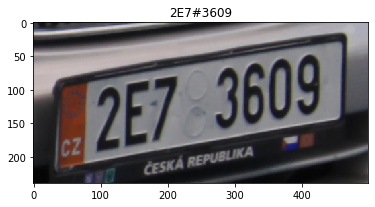

Predicted number plate is 1BI#1110 and actual number plate text is 1BI#1710 for image ./HDR data/./crop_h4/I00061.png and is correctly Identified ?False


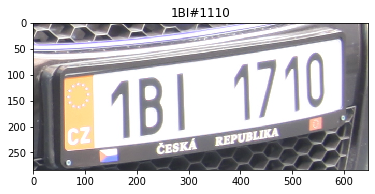

Predicted number plate is 2B5#7527 and actual number plate text is 2B5#7127 for image ./HDR data/./crop_h3/I00038.png and is correctly Identified ?False


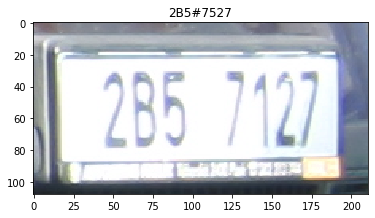

Predicted number plate is 4B8#3172 and actual number plate text is 4B8#3172 for image ./HDR data/./crop_m4/I00060.png and is correctly Identified ?True


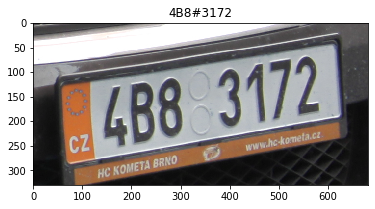

Predicted number plate is 8B9#0164 and actual number plate text is 8B9#0164 for image ./HDR data/./crop_h1/I00005.png and is correctly Identified ?True


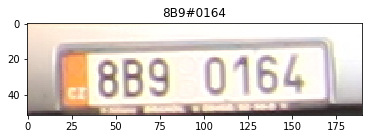

3/5 correct 


In [53]:
randomindexes = np.random.randint(0,len(evaluationset)-1, 5)
print('randomindexes', randomindexes)
correct = 0
for i in range(0, len(randomindexes)):
    index = randomindexes[i]
    image,label,image_path = evaluationset[index]
    image , label = image.cuda(), label.cuda()
    output = model_scratch(image.unsqueeze(dim=0))
    output = output.permute((1,2,0))
    pred = output.max(dim=1, keepdim=True)[1].squeeze()
    predword = reverttoword(pred)
    actualword = reverttoword(label)
    iscorrect =False
    if(predword == actualword):
        correct += 1
        iscorrect =True
    print('Predicted number plate is '+predword+' and actual number plate text is '+actualword+' for image '+image_path+' and is correctly Identified ?'+str(iscorrect))
    plot_images(image_path, predword)
print(str(correct)+'/'+str(len(randomindexes))+' correct ')
    